In [41]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 - 0.5
x_test = x_test.astype("float32") / 255 - 0.5
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [42]:
import numpy as np
y_train_non_hot = np.argmax(y_train, axis=1)
y_test_non_hot = np.argmax(y_test, axis=1)
y_train2 = (y_train_non_hot == 5).astype("uint16")
y_test2 = (y_test_non_hot == 5).astype("uint16")

In [60]:
init, binit = keras.initializers.HeNormal(), keras.initializers.HeNormal()
regularizer = keras.regularizers.l2()
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dropout(0.05),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu",
                                  kernel_initializer=init,
                                  bias_initializer=binit,
                                  kernel_regularizer=regularizer),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu",
                                  kernel_initializer=init,
                                  bias_initializer=binit,
                                  kernel_regularizer=regularizer),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu",
                                  kernel_initializer=init,
                                  bias_initializer=binit,
                                  kernel_regularizer=regularizer),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="linear"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)         

In [61]:
a = sum(y_train2)
b = len(y_train2) - sum(y_train2)
# Class 0 is by default twice as important as class 1 to favor precision over accuracy
class_weights = {0: (1 / b) * (a + b) / 2, 1: (1 / a) * (a + b) / 2}

In [42]:
class_weights

{0: 0.549661957895894, 1: 5.534034311012728}

In [62]:
batch_size = 128
epochs = 13

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.01), optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train2, batch_size=batch_size, epochs=epochs, validation_split=0.1, class_weight=class_weights)

Epoch 1/13
422/422 [==============================] - 1s 2ms/step - loss: 1.4182 - accuracy: 0.9510 - val_loss: 0.7193 - val_accuracy: 0.9433
Epoch 2/13
422/422 [==============================] - 1s 2ms/step - loss: 0.4366 - accuracy: 0.9762 - val_loss: 0.2879 - val_accuracy: 0.9885
Epoch 3/13
422/422 [==============================] - 1s 3ms/step - loss: 0.2883 - accuracy: 0.9778 - val_loss: 0.2339 - val_accuracy: 0.9863
Epoch 4/13
422/422 [==============================] - 1s 3ms/step - loss: 0.2431 - accuracy: 0.9781 - val_loss: 0.1981 - val_accuracy: 0.9892
Epoch 5/13
422/422 [==============================] - 1s 3ms/step - loss: 0.2219 - accuracy: 0.9800 - val_loss: 0.1827 - val_accuracy: 0.9877
Epoch 6/13
422/422 [==============================] - 1s 2ms/step - loss: 0.2103 - accuracy: 0.9808 - val_loss: 0.1813 - val_accuracy: 0.9882
Epoch 7/13
422/422 [==============================] - 1s 2ms/step - loss: 0.2044 - accuracy: 0.9802 - val_loss: 0.1861 - val_accuracy: 0.9880
Epoch 

In [138]:
score = model.evaluate(x_test, y_test2, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 0s 929us/step - loss: 0.1474 - accuracy: 0.9901
Test loss: 0.14735132455825806
Test accuracy: 0.9901000261306763


In [45]:
def put_in_bags(org_labels):
    bagsize = 5
    labels = np.zeros(org_labels.shape)
    for j in range(int(org_labels.size / bagsize)):
        true_instances = org_labels[bagsize*j:bagsize*j+bagsize] == 1
        labels[bagsize*j:bagsize*j+bagsize] = np.logical_or(true_instances, np.any(true_instances))
    if org_labels.size % bagsize != 0:
        true_instances = org_labels[bagsize*j:bagsize*j+bagsize] == 1
        labels[-(org_labels.size % bagsize):] = np.logical_or(true_instances, np.any(true_instances))
    return labels

In [46]:
y_test3 = put_in_bags(y_test2)
y_train3 = put_in_bags(y_train2)

In [47]:
a = sum(y_train3)
b = len(y_train3) - sum(y_train3)
# Class 0 is by default twice as important as class 1 to favor precision over accuracy
class_weights = {0: (1 / b) * (a + b) / 2, 1: (1 / a) * (a + b) / 2}

In [48]:
batch_size = 128
epochs = 20

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.01), optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train3, batch_size=batch_size, epochs=epochs, validation_split=0.1, class_weight=class_weights)

Epoch 1/20


2022-09-28 16:23:06.279030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-09-28 16:23:06.996693: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 16:23:06.996952: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 16:23:06.996965: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-28 16:23:06.997198: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 16:23:06.997229: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-28 16:23:07.605423: I tensorflow/stream_executor/cuda/c

422/422 [==============================] - 4s 2ms/step - loss: 1.5690 - accuracy: 0.6470 - val_loss: 0.8478 - val_accuracy: 0.6855
Epoch 2/20
422/422 [==============================] - 1s 2ms/step - loss: 0.7680 - accuracy: 0.6724 - val_loss: 0.7206 - val_accuracy: 0.6845
Epoch 3/20
422/422 [==============================] - 1s 2ms/step - loss: 0.7001 - accuracy: 0.6755 - val_loss: 0.6796 - val_accuracy: 0.6885
Epoch 4/20
422/422 [==============================] - 1s 2ms/step - loss: 0.6861 - accuracy: 0.6782 - val_loss: 0.6786 - val_accuracy: 0.6845
Epoch 5/20
422/422 [==============================] - 1s 2ms/step - loss: 0.6818 - accuracy: 0.6800 - val_loss: 0.6661 - val_accuracy: 0.6892
Epoch 6/20
422/422 [==============================] - 1s 2ms/step - loss: 0.6777 - accuracy: 0.6811 - val_loss: 0.6578 - val_accuracy: 0.6882
Epoch 7/20
422/422 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.6825 - val_loss: 0.6713 - val_accuracy: 0.6845
Epoch 8/20
422/42

In [51]:
test_prediction_3 = model.predict(x_test)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

norm= plt.Normalize(-2,2)
cmap = matplotlib.colors.ListedColormap(["palegreen","green","darkgreen"])

In [57]:
pallete = ["#DDFFDD", "#BBFFBB", "#88FF88", "#55FF56", "00FF00", "FF5555", "00FF00", "00CC00", "006600", "003300"]

In [58]:
pallete

['#DDFFDD',
 '#BBFFBB',
 '#88FF88',
 '#55FF56',
 '00FF00',
 'FF5555',
 '00FF00',
 '00CC00',
 '006600',
 '003300']

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(
    {"Prediction": test_prediction_3.reshape(-1, ), "MNIST value": y_test_non_hot})
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(5, 5))
sns.boxplot(x="MNIST value", y="Prediction", data=df, palette=["#DDFFDD", "#BBFFBB", "#88FF88",
                                                               "#55FF56", "#00FF00",
                                                               "#FF5555", "#00FF00", "#00CC00", "#006600", "#003300"])
#plt.title("Label Noise Predictions Sorted by Underlying Label")
plt.tight_layout()
plt.savefig("results/mnist_label_noise.png")
plt.show()

ValueError: Could not generate a palette for <map object at 0x7f73cc5361d0>

<Figure size 360x360 with 0 Axes>

In [52]:
m = keras.metrics.BinaryAccuracy(threshold=0.538)
m.update_state(y_test2, test_prediction_3)
m.result().numpy()

0.9515

In [53]:
metrics.roc_auc_score(y_test2, test_prediction_3)

0.9929931504556188

In [14]:
model.evaluate(x_test, y_test2)

313/313 [==============================] - 0s 1ms/step - loss: 0.5773 - accuracy: 0.9809


[0.5772793889045715, 0.98089998960495]

In [ ]:
model.evaluate(x_test, y_test3)

In [51]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test2, test_prediction_3, pos_label=1)
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_threshold = threshold[index]
best_threshold

0.53841823

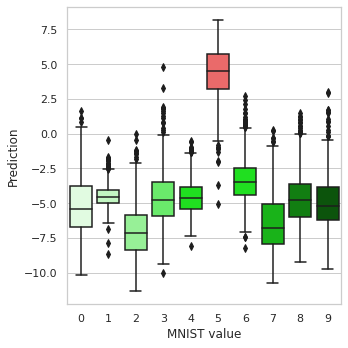

In [64]:
test_prediction = model.predict(x_test)
df = pd.DataFrame(
    {"Prediction": test_prediction.reshape(-1, ), "MNIST value": y_test_non_hot})
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(5, 5))
sns.boxplot(x="MNIST value", y="Prediction", data=df, palette=["#DDFFDD", "#BBFFBB", "#88FF88",
                                                               "#55FF56", "#00FF00",
                                                               "#FF5555", "#00FF00", "#00CC00", "#009000", "#006000"])
#plt.title("Binary Predictions Sorted by Underlying Label")
plt.tight_layout()
plt.savefig("results/mnist_normal.png")
plt.show()

In [140]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test2, test_prediction, pos_label=1)
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_threshold = threshold[index]
best_threshold

0.0660734

In [141]:
metrics.roc_auc_score(y_test2, test_prediction)

0.9987642066994767

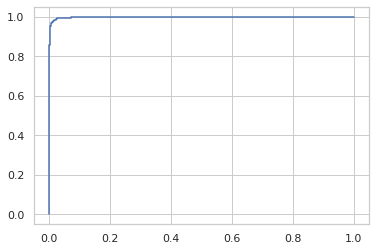

In [98]:
plt.plot(fpr, tpr)

In [99]:
model.evaluate(x_test, y_test2)

313/313 [==============================] - 0s 873us/step - loss: 0.1506 - accuracy: 0.9887


[0.15063835680484772, 0.9886999726295471]

Label
0.0
Prediction
[-0.27949557]
Label
0.0
Prediction
[-0.1971034]
Label
0.0
Prediction
[-0.2375522]
Label
0.0
Prediction
[-0.31759387]
Label
0.0
Prediction
[-0.2732393]
Label
1.0
Prediction
[1.0972093]
Label
1.0
Prediction
[-0.30765185]
Label
1.0
Prediction
[-0.39188415]
Label
1.0
Prediction
[-0.19702053]
Label
1.0
Prediction
[-0.20277828]
Label
1.0
Prediction
[-0.20655492]
Label
1.0
Prediction
[-0.06738292]
Label
1.0
Prediction
[-0.21075313]
Label
1.0
Prediction
[1.350722]
Label
1.0
Prediction
[-0.21068725]


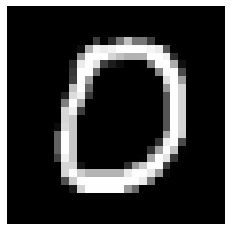

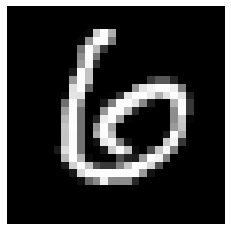

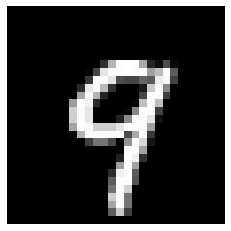

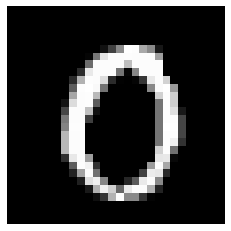

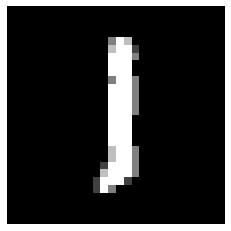

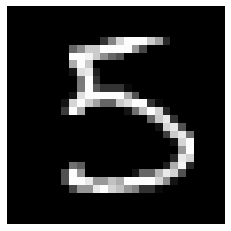

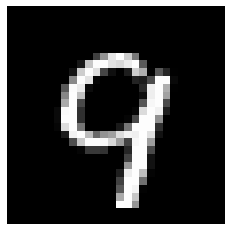

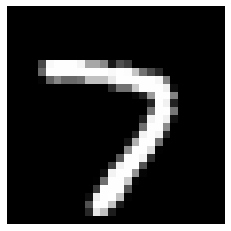

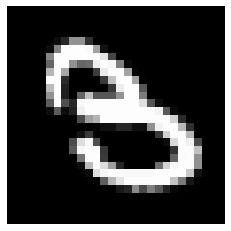

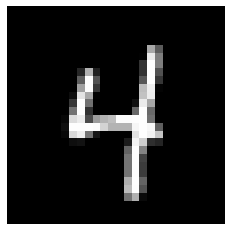

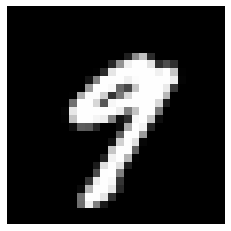

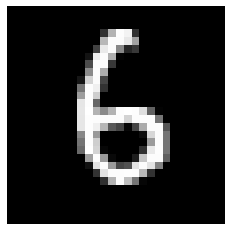

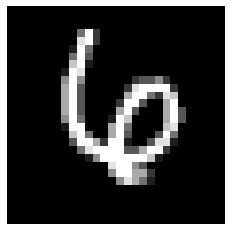

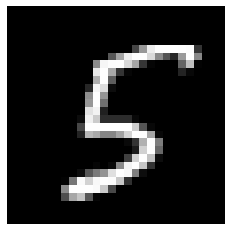

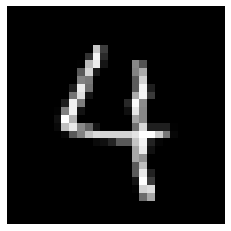

In [29]:
for mnist_number, label, prediction in zip(x_test[10:25], y_test3[10:25], test_prediction_3[10:25]):
    plt.figure()
    plt.axis(False)
    plt.grid(False)
    print("Label")
    print(label)
    print("Prediction")
    print(prediction)
    plt.imshow(mnist_number, cmap="gray")